## 讀取資料

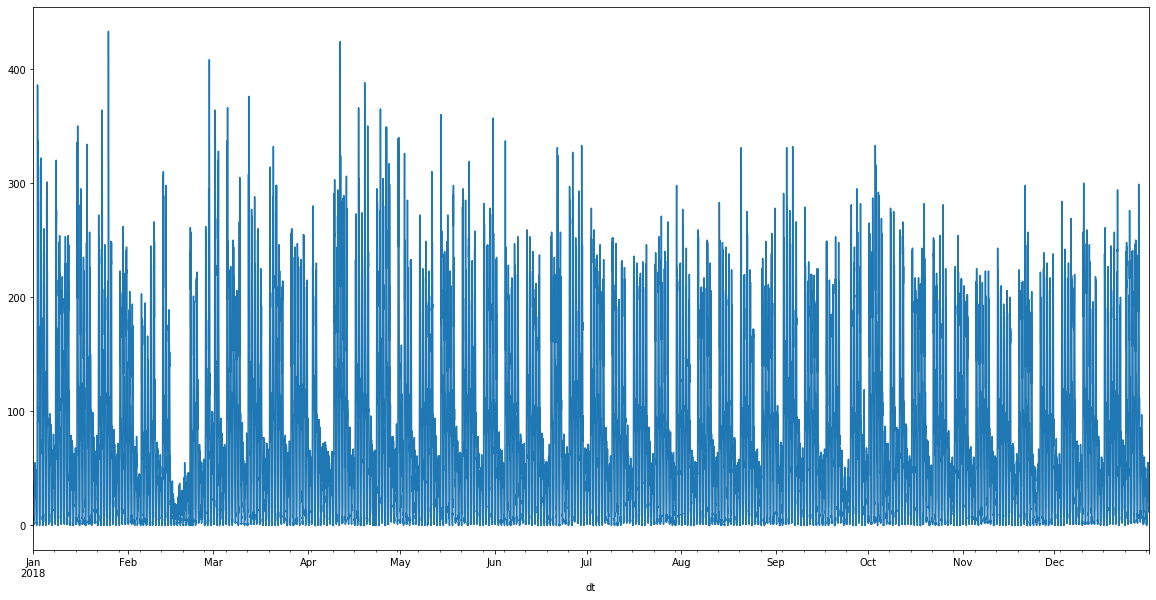

In [1]:
%matplotlib inline
import pandas
df = pandas.read_csv('/Users/davidchiu/course/cathayts/data_edited_2018.csv')
df['dt'] = df['date'] + ' ' + df['time']
df['dt'] = pandas.to_datetime(df['dt'], format = '%Y/%m/%d %H:%M')
df.set_index('dt', inplace=True)
df['y'].plot(kind = 'line', figsize = [20,10])

## 資料預處理

In [2]:
df['sms'] = df['sms'].fillna(0)

In [3]:
df['hour'] = df.index.hour 
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 

In [4]:
df = df[['y', 'sms','hour','dayofweek','month', 'season', 'workday']]

In [5]:
df.head(3)

,y,sms,hour,dayofweek,month,season,workday
dt,,,,,,,
2018-01-01 00:00:00,10,0.0,0,0,1,1,0
2018-01-01 00:30:00,6,0.0,0,0,1,1,0
2018-01-01 01:00:00,4,0.0,1,0,1,1,0


##  轉換虛擬變數

In [6]:
columns_to_cat = ['sms','hour', 'dayofweek', 'month','season']
df[columns_to_cat] = df[columns_to_cat].astype('category')

data = pandas.get_dummies(df, columns=columns_to_cat) 
data.head(3)

,y,workday,sms_0.0,sms_1.0,sms_2.0,sms_3.0,sms_4.0,hour_0,hour_1,hour_2,...,month_7,month_8,month_9,month_10,month_11,month_12,season_1,season_2,season_3,season_4
dt,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,10,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-01 00:30:00,6,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-01 01:00:00,4,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
# 增加一個原欄位y 的copy, 以利df_to_lstm_format 前期的y 變為變數
data['y_copy'] = data['y']
data.head(3)

,y,workday,sms_0.0,sms_1.0,sms_2.0,sms_3.0,sms_4.0,hour_0,hour_1,hour_2,...,month_8,month_9,month_10,month_11,month_12,season_1,season_2,season_3,season_4,y_copy
dt,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,10,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,10
2018-01-01 00:30:00,6,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,6
2018-01-01 01:00:00,4,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,4


## 將 DataFrame 轉變為 LSTM 格式

In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def df_to_lstm_format(df, test_size=0.5, look_back=5, target_column='target', scale_X=True):

    df = df.copy()

    # 最後一個欄位為預測目標
    df['target'] = df[target_column] 
    # 捨棄 y
    df = df.drop(columns=[target_column]) 
    
    # 取得目標 y
    target_location = df.shape[1] - 1 
    
    # 根據 test_size 比例分割資料
    split_index = int(df.shape[0]*test_size) 
    
    # 訓練資料集
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # 測試資料集
    X_test = df.values[split_index:, :target_location] 
    y_test = df.values[split_index:, target_location] 

    # 將資料正規化 (如果 scale_X 為True)
    if scale_X:
        scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
        X_train = scalerX.transform(X_train)
        X_test = scalerX.transform(X_test)
        
    # 重塑輸入矩陣
    samples = len(X_train) 
    num_features = target_location 

    samples_train = X_train.shape[0] - look_back
    
    # 重塑訓練資料
    # (資料筆數, 往前看多少筆, 特徵數量)
    X_train_reshaped = np.zeros((samples_train, look_back, num_features))
    y_train_reshaped = np.zeros((samples_train))

    
    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]

    # 重塑測試資料
    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

## 計算 mape 與 smape

In [16]:
import keras.backend as K
def mape(y_true, y_pred):
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

In [17]:
look_back = 7*48
test_size = 0.8


X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, 
                                                     test_size=test_size, 
                                                     look_back=look_back, 
                                                     target_column='y', scale_X=True)

# 建立編碼器與解碼器所需numpy array
encoder_input_train = X_train
decoder_input_train = np.zeros((X_train.shape[0], X_train.shape[1], 1)) # Zeros array
decoder_output_train = y_train.reshape((y_train.shape[0], 1, 1))

encoder_input_test = X_test
decoder_input_test = np.zeros((X_test.shape[0], X_test.shape[1], 1)) # Zeros array
decoder_output_test = y_test.reshape((y_test.shape[0], 1, 1))

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Seq2Seq (GRU版本)

In [18]:
import numpy as np
import keras
import matplotlib.pyplot as plt

## 編碼器 (Encoder)

In [19]:
num_features = data.shape[1] - 1
layers = [50,50,]

# 定義輸入序列
encoder_inputs = keras.layers.Input(shape=(None, num_features))


# 建立 Encoder
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_initializer='TruncatedNormal'))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# 只保留狀態，不保留輸出
encoder_states = encoder_outputs_and_states[1:]

## 解碼器 (Decoder)

In [20]:
output_dim = 1

decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                             kernel_initializer='TruncatedNormal'))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# 將encoder 的輸出設定為decoder 起始狀態
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# 只取得output，不用 state
decoder_outputs = decoder_outputs_and_states[0]

# 產生預測結果
decoder_dense = keras.layers.Dense(output_dim,
                                   activation='linear')

decoder_outputs = decoder_dense(decoder_outputs)

# 建立且編譯模型

In [21]:
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer='adam', loss='mse', metrics=[mape, smape])

## 訓練模型

In [ ]:
from time import time
epochs = 1
model.fit([encoder_input_train, decoder_input_train], decoder_output_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_output_test), 
          epochs=epochs, verbose=1)

print(model.summary())


Train on 13680 samples, validate on 3168 samples
Epoch 1/1
10848/13680 [======================>.......] - ETA: 1:49 - loss: 10008.2813 - mape: inf - smape: 59.0056

## 產生預測結果

In [40]:
encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

for hidden_neurons in layers[::-1]:
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

In [41]:
def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    y_predicted = []

    # 將輸入值轉變為狀態向量
    states = encoder_predict_model.predict(x)

    # 狀態向量必須是 list
    if not isinstance(states, list):
        states = [states]

    # 產生第一筆解碼值
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # 增加預測結果
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

In [42]:
# 每次只預測下一筆
num_steps_to_predict = 1
batch_size = 1

y_preds= predict(X_test, encoder_predict_model, decoder_predict_model, num_steps_to_predict)
y_preds = y_preds.reshape(y_preds.shape[0])
y_preds.shape

(3168,)

In [43]:
y_true = y_test.reshape(y_test.shape[0])
y_true.shape

(3168,)

In [44]:
split_index = int(data.shape[0]*test_size)
x = data[split_index:]

In [45]:
datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # 修正延遲數
x.index.shape

(3168,)

## 評估預測結果

3168/3168 [==============================] - 8s 3ms/step


Text(0.5, 1.0, 'Seq2Seq \n MSE = 191.16 \n MAPE = 58.0 [%] \n SMAPE = 13.8 [%]')

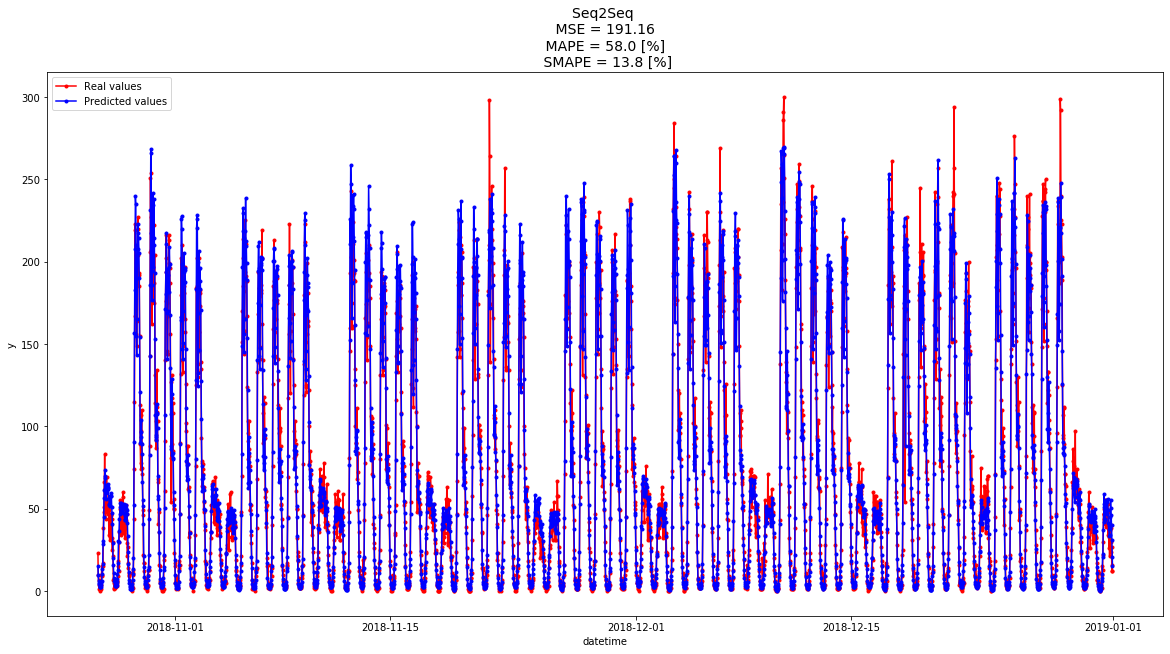

In [47]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values')
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel('y')
plt.xlabel('datetime')
plt.legend()

mse = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[0]
mape = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[1]
smape = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[2]

plt.title('Seq2Seq \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse, mape, smape), fontsize = 14)


## 以天為單位比對預測結果

In [49]:
split_index = int(data.shape[0]*test_size)
x = data[split_index:]

# 修正預測跟實際值差距的數值
datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] 

# 比對預測與實際值
datetime = x.index
y_preds = y_preds.reshape(y_preds.shape[0])
y_true = y_true.reshape(y_true.shape[0])
results = pandas.DataFrame(y_true, y_preds) 
result = results.reset_index() 
result.columns = ['y_pred', 'y_true']
result['datetime'] = datetime
result = result.set_index(['datetime'])

# 重新取樣
result = result.resample('D').sum()
# 去除Nan
result = result.dropna()

In [50]:
# 比較預測與實際值

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)

mse = (1/n)*np.sum((ypred - ytrue)**2)
mape = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

Text(0.5, 1.0, 'Seq2Seq By Day \n MSE = 35531.23 \n MAPE = 4.8 [%] \n SMAPE = 2.5 [%]')

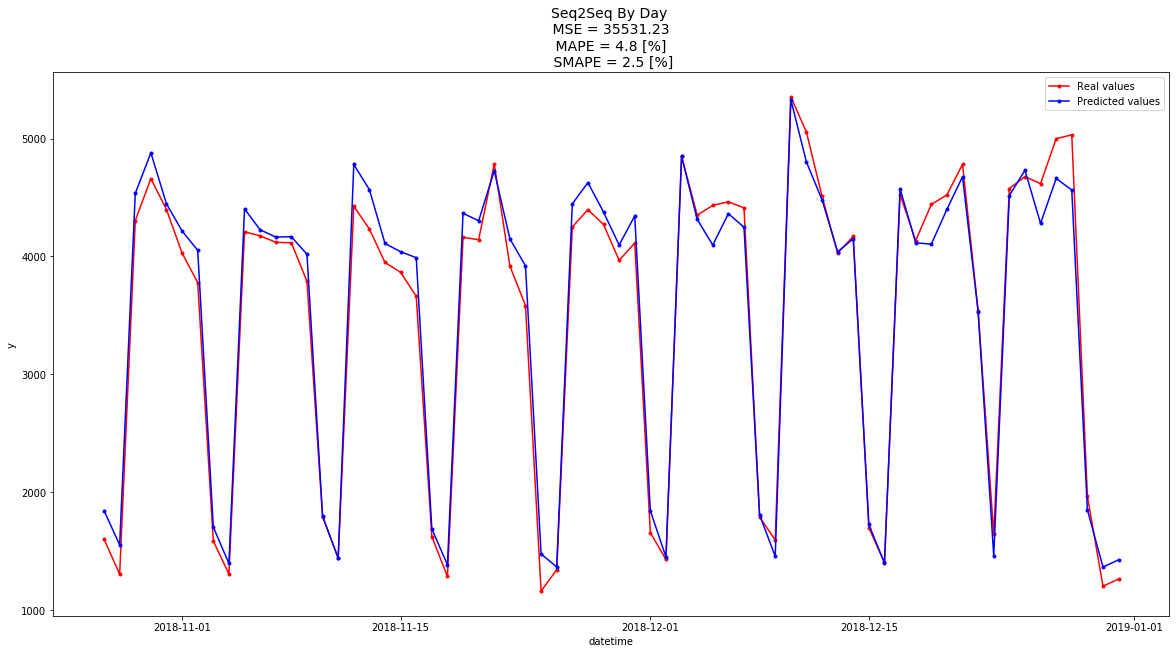

In [53]:
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values') 
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values')

plt.ylabel('y')
plt.xlabel('datetime')
plt.legend()

plt.title('Seq2Seq By Day \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse, mape, smape), fontsize = 14)

## 儲存模型

In [56]:
model.save('seq2seq_30_iters_2.h5')

## 讀取模型

In [60]:
import keras
import keras.backend as K
def mape(y_true, y_pred):
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"smape": smape})


m2 = keras.models.load_model('seq2seq_30_iters_2.h5')

In [61]:
m2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 54)     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
rnn_3 (RNN)                     [(None, 50), (None,  30900       input_3[0][0]                    
__________________________________________________________________________________________________
rnn_5 (RNN)                     [(None, None, 50), ( 22950       input_5[0][0]                    
                                                                 rnn_3[0][1]                